In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [111]:
data = pd.read_csv("train.csv")

In [112]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [113]:
def is_numeric_column(column):
    try:
        pd.to_numeric(column, errors='raise')
        return True
    except ValueError:
        return False
def prepare_data_auto(data):
    data['LotFrontage'] = data['LotFrontage'].fillna(data['LotFrontage'].mean())
    data.drop(['Alley'], axis=1,inplace=True)
    data.drop(['FireplaceQu'], axis=1,inplace=True)
    data.drop(['PoolQC'], axis=1,inplace=True)
    data.drop(['Fence'], axis=1,inplace=True)
    data.drop(['MiscFeature'], axis=1,inplace=True)
    data_map={}
    for column in data.columns:
        if data[column].isnull().sum()>0:
            data[column] = data[column].fillna(data[column].mode()[0])
        if not is_numeric_column(data[column]):
            unique_values=data[column].unique().tolist()
            unique_values.sort()
            values_dict={}
            index=0
            for i in unique_values:
                values_dict[i]=index
                index+=1
            data[column]=data[column].map(values_dict)
            data_map[column]=values_dict
        elif column!='SalePrice':
            max_value = data[column].max()
            data[column] = data[column]/max_value
    return data_map
def prepare_data_test(data,data_map):
    data['LotFrontage'] = data['LotFrontage'].fillna(data['LotFrontage'].mean())
    data.drop(['Alley'], axis=1,inplace=True)
    data.drop(['FireplaceQu'], axis=1,inplace=True)
    data.drop(['PoolQC'], axis=1,inplace=True)
    data.drop(['Fence'], axis=1,inplace=True)
    data.drop(['MiscFeature'], axis=1,inplace=True)
    for column in data.columns:
        if data[column].isnull().sum()>0:
            data[column] = data[column].fillna(data[column].mode()[0])
        if not is_numeric_column(data[column]):
            values_dict=data_map[column] 
            data[column]=data[column].map(values_dict)
        elif column!='SalePrice':
            max_value = data[column].max()
            data[column] = data[column]/max_value

In [114]:
data.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

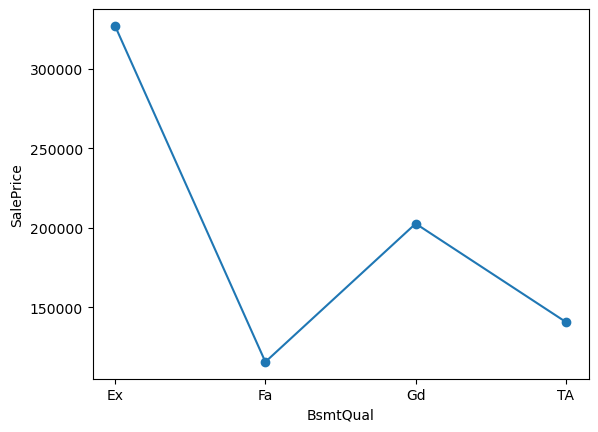

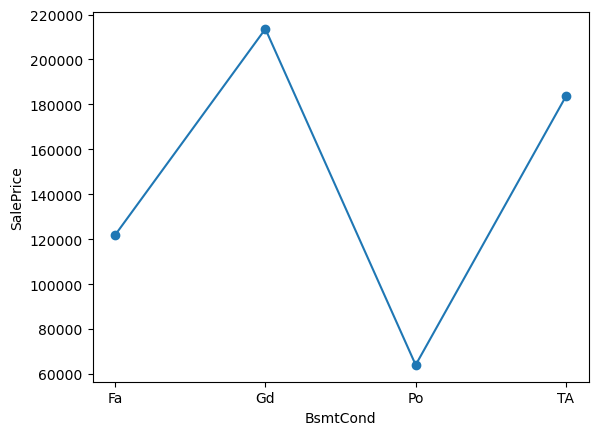

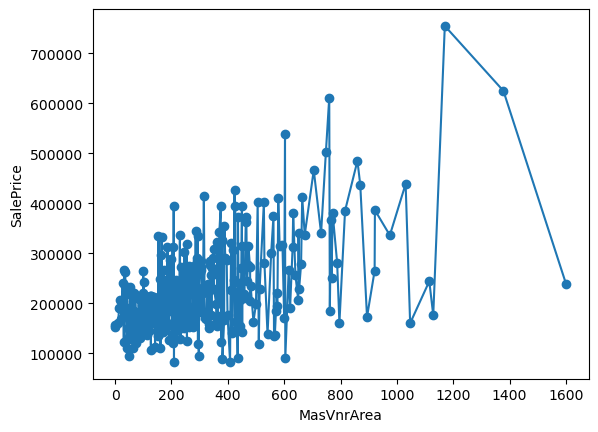

In [115]:
params = ['BsmtQual','BsmtCond','MasVnrArea']
for param in params:
    class_price = data.groupby(param)[['SalePrice']].mean()
    param_values = class_price.index.values
    saleprice_values = class_price['SalePrice'].values
    plt.plot(param_values, saleprice_values, 'o-')
    
    # Добавьте название осей
    plt.xlabel(param)
    plt.ylabel('SalePrice')
    
    # Показатьграфик
    plt.show()

In [116]:
data_map = prepare_data_auto(data)
data.isnull().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 76, dtype: int64

In [117]:
data.head(20)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0.000685,0.315789,3,0.207668,0.039258,1,3,3,0,4,...,0.000000,0.000000,0.000000,0.0,0.000000,0.166667,0.999005,8,4,208500
1,0.001370,0.105263,3,0.255591,0.044600,1,3,3,0,2,...,0.000000,0.000000,0.000000,0.0,0.000000,0.416667,0.998507,8,4,181500
2,0.002055,0.315789,3,0.217252,0.052266,1,0,3,0,4,...,0.000000,0.000000,0.000000,0.0,0.000000,0.750000,0.999005,8,4,223500
3,0.002740,0.368421,3,0.191693,0.044368,1,0,3,0,0,...,0.492754,0.000000,0.000000,0.0,0.000000,0.166667,0.998010,8,0,140000
4,0.003425,0.315789,3,0.268371,0.066250,1,0,3,0,2,...,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.999005,8,4,250000
5,0.004110,0.263158,3,0.271565,0.065576,1,0,3,0,4,...,0.000000,0.629921,0.000000,0.0,0.045161,0.833333,0.999502,8,4,143000
6,0.004795,0.105263,3,0.239617,0.046849,1,3,3,0,4,...,0.000000,0.000000,0.000000,0.0,0.000000,0.666667,0.998507,8,4,307000
7,0.005479,0.315789,3,0.223802,0.048233,1,0,3,0,0,...,0.413043,0.000000,0.000000,0.0,0.022581,0.916667,0.999502,8,4,200000
8,0.006164,0.263158,4,0.162939,0.028433,1,3,3,0,4,...,0.371377,0.000000,0.000000,0.0,0.000000,0.333333,0.999005,8,0,129900
9,0.006849,1.000000,3,0.159744,0.034472,1,3,3,0,0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.083333,0.999005,8,4,118000


Text(0.5, 1.0, 'Распределение SalePrice')

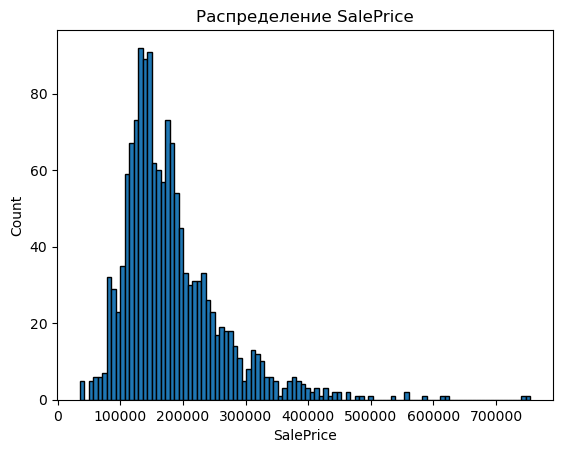

In [118]:
plt.hist(data['SalePrice'], bins=100, edgecolor='black')

# Добавьте название осей
plt.xlabel('SalePrice')
plt.ylabel('Count')

# Добавьте заголовок графика
plt.title('Распределение SalePrice')

In [119]:
train_target = data['SalePrice']
drop_params = ['Id', 'LotArea','MasVnrArea']
#drop_params = data.drop(['OverallQual','OverallCond', 'SalePrice','ExterQual', 'ExterCond','SaleCondition','SaleType','Electrical','BsmtQual','BsmtCond'], axis=1)
train_data = data.drop(drop_params, axis=1)
train_data = train_data.drop('SalePrice', axis=1)

In [120]:
model = LGBMRegressor(random_state=10, objective='mae', learning_rate=0.247332, n_estimators=300, num_leaves=30, max_depth=12, feature_fraction = 0.89952, min_data_in_leaf = 10)

In [121]:
model.fit(train_data, train_target, eval_metric='mae')

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.89952, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.89952
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.89952, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.89952
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2908
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 68
[LightGBM] [Info] Start training from score 163000.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

LGBMRegressor(feature_fraction=0.89952, learning_rate=0.247332, max_depth=12,
              min_data_in_leaf=10, n_estimators=300, num_leaves=30,
              objective='mae', random_state=10)

In [122]:
test_data = pd.read_csv("test.csv")
test_target = pd.read_csv("sample_submission.csv")

In [123]:
prepare_data_test(test_data,data_map)
test_data.isnull().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 75, dtype: int64

In [124]:
test_data=test_data.drop(drop_params, axis=1)
test_target=test_target['SalePrice']

In [125]:
prediction = model.predict(test_data)
for i in range(0,30):
    print(prediction[i])

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.89952, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.89952
130840.92873865362
177076.74786042655
182981.1397497208
200088.78718439746
204570.302227359
192888.85630988106
169611.7844513531
184300.4756153487
235195.03316301838
132274.27511129857
225998.4863699358
95904.86549667032
105908.89072711994
158568.66696991998
137952.22877999407
382161.26269206475
297208.3365165242
342391.24876260845
322341.763380372
472747.0620438123
345058.73849740776
216046.76918452667
185984.393452347
188215.83138860957
167275.05217418566
218843.282379832
368770.3957019784
263072.4625193487
215017.06507209133
255768.46614725186


In [127]:
metrics = metrics.mean_squared_error(test_target, prediction)
metrics

5950525021.049621

In [128]:
diviation = []
for i in range(0,len(prediction)):
    diviation.append(abs(prediction[i]-test_target[i]))
mean_div = sum(diviation)/len(diviation)
print(mean_div)

55698.29478903497


In [ ]:
plt.plot(test_target[0:300], label='Real')
plt.plot(prediction[0:300], label='Prediction')

# Добавляем легенду
plt.legend()

# Добавляем название осей
plt.xlabel('Index')
plt.ylabel('Value')

# Добавляем заголовок графика
plt.title('Real vs Prediction')

# Показываем график
plt.show()